In [1]:
import os,sys,time
import numpy as np
from scipy.io import wavfile
import sklearn

from IPython.display import Audio

import musiclib, database

%load_ext cython

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# DTW

In [2]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef align(float[:,:] sig1,float[:,:] sig2):
    cdef int d = sig1.shape[1]
    cdef int len1 = sig1.shape[0]
    cdef int len2 = sig2.shape[0]
    cdef np.ndarray[np.float32_t, ndim=2] npL = np.empty((len1,len2), dtype=np.float32)
    cdef np.ndarray[np.float32_t, ndim=2] npP = np.empty((len1,len2), dtype=np.float32)
    
    cdef float[:,:] L = npL
    cdef float[:,:] P = npP
    
    cdef float cost,tmp
    cdef int j,k,i
    for j in range(0,len1):
        for k in range(0,len2):
            cost = 0
            for i in range(d):
                tmp = sig1[j,i] - sig2[k,i]
                cost += tmp * tmp
            cost = sqrt(cost)
            
            if j == 0 and k == 0:
                L[j,k] = cost
                P[j,k] = 3
            elif k == 0:
                L[j,k] = cost + L[j-1,k]
                P[j,k] = 2
            elif j == 0:
                L[j,k] = cost + L[j,k-1]
                P[j,k] = 1
            else: # j, k > 0
                if L[j-1,k] < L[j,k-1] and L[j-1,k] < L[j-1,k-1]: # insertion (up)
                    P[j,k] = 1
                    L[j,k] = cost + L[j-1,k]
                elif L[j,k-1] < L[j-1,k-1]: # deletion (left)
                    P[j,k] = 2
                    L[j,k] = cost + L[j,k-1]
                else: # match (up left)
                    P[j,k] = 3
                    L[j,k] = cost + L[j-1,k-1]
    
    return npL,npP

In [3]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

def traceback_loss(float[:,:] sig1,float[:,:] sig2, float[:,:] L):
    sig12 = np.zeros(sig2.shape) # align 1 onto 2
    cdef int j = sig1.shape[0]-1
    cdef int k = sig2.shape[0]-1
    A = []
    C = []
    cdef float cost,tmp
    while True:
        if j == 0 and k == 0:
            A.append((0,0))
            C.append(L[0,0])
            break # got back to the beginning
        
        cost = 0
        for i in range(sig1.shape[1]):
            tmp = sig1[j,i] - sig2[k,i]
            cost += tmp * tmp
        cost = sqrt(cost)
        
        if j>0 and k>0 and L[j,k] == L[j-1,k-1] + cost: # progress
            A.append((j,k))
            C.append(L[j,k])
            j -= 1
            k -= 1
        elif k>0 and L[j,k] == L[j,k-1] + cost: # stay sig2
            A.append((j,k))
            C.append(L[j,k])
            k -= 1
        elif j>0 and L[j,k] == L[j-1,k] + cost: # stay sig1
            A.append((j,k))
            C.append(L[j,k])
            j -= 1
        else: 
#             print 'j',j
#             print 'k',k
#             print 'cost',cost
#             print 'L[j,k]',L[j,k]
#             print 'L[j,k]-cost',L[j,k]-cost
#             print 'L[j,k-1]',L[j,k-1]
#             print 'L[j-1,k]',L[j-1,k]
#             print 'L[j-1,k-1]',L[j-1,k-1]
            assert False
    
    return list(reversed(A)),list(reversed(C))

In [4]:
window_size=2048
stride=512
cutoff=int(50*(window_size/2048.))

In [5]:
record = 'MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_16_R1_2015_wav--1.wav'
synth = 'wtc1p19.wav'

fs, data1 = wavfile.read(record)
left_pad = 1*fs
right_pad = 0*fs
data1 = data1[0:int(9.8*fs)]
data1 = np.concatenate((np.zeros((left_pad,2)),data1),axis=0)
frep1 = database.featurize(data1,fs,musiclib.feature,window_size,stride=stride,normalize=False)

fs, data2 = wavfile.read(synth)
data2 = data2[0:fs*10]
data2 = np.concatenate((np.zeros((left_pad,2)),data2),axis=0)
frep2 = database.featurize(data2,fs,musiclib.feature,window_size,stride=stride,normalize=False)

/Users/harshverma/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [6]:
Audio(data1[:,0],rate=fs)

In [7]:
Audio(data2[:,0],rate=fs)

In [8]:
# Align signals
start = time.time()
L,P = align(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32))
end = time.time()
print('Elapsed time: ' + str(end - start))

Elapsed time: 0.07067489624023438


In [9]:
# Find optimal path
path,costs = traceback_loss(frep1[0:cutoff].T.astype(np.float32),frep2[0:cutoff].T.astype(np.float32),L)

In [10]:
path1 = np.array([x[0] for x in path])
path2 = np.array([x[1] for x in path])

In [11]:
# Find corresponding onsets on the performance
notes_onsets_offsets_2 = musiclib.load_midi('wtc1p19.mid')
for i, e in list(enumerate(notes_onsets_offsets_2)):
    notes_onsets_offsets_2[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_1 = []    
for note, onset, offset in notes_onsets_offsets_2:
    if (onset > path2[-1] - right_pad/stride) or (offset > path2[-1] - right_pad/stride):
        break
    sig2_onset_index = np.argmax(path2>=int(onset))
    sig2_offset_index = np.argmax(path2>=int(offset))
    sig1_onset = path1[sig2_onset_index]
    sig1_offset = path1[sig2_offset_index]
    notes_onsets_offsets_1.append((note, sig1_onset, sig1_offset))
notes_onsets_offsets_1 = np.array(notes_onsets_offsets_1)
print(notes_onsets_offsets_1)

length of midi file69.2797896166662
[[ 45 174 222]
 [ 69 174 187]
 [ 71 187 200]
 [ 73 200 212]
 [ 69 212 222]
 [ 78 222 248]
 [ 57 222 279]
 [ 78 248 279]
 [ 56 279 337]
 [ 78 279 292]
 [ 75 292 307]
 [ 76 307 337]
 [ 55 337 392]
 [ 76 351 362]
 [ 78 362 375]
 [ 64 362 417]
 [ 79 375 392]
 [ 54 392 447]
 [ 81 392 403]
 [ 79 403 417]
 [ 57 417 447]
 [ 78 417 432]
 [ 81 432 447]
 [ 59 447 499]
 [ 74 447 461]
 [ 73 461 472]
 [ 62 472 525]
 [ 71 472 484]
 [ 81 484 499]
 [ 52 499 551]
 [ 80 499 512]
 [ 78 512 525]
 [ 56 525 551]
 [ 76 525 538]
 [ 80 538 551]
 [ 73 551 566]
 [ 57 551 608]
 [ 71 566 579]
 [ 69 579 592]
 [ 61 579 633]
 [ 79 592 608]
 [ 78 608 620]
 [ 50 608 661]
 [ 76 620 633]
 [ 74 633 647]
 [ 59 633 647]
 [ 57 647 661]
 [ 78 647 661]
 [ 56 661 701]
 [ 52 661 717]
 [ 71 661 672]
 [ 78 672 684]
 [ 76 684 701]
 [ 74 701 717]
 [ 56 701 717]
 [ 73 717 728]
 [ 57 717 742]
 [ 45 717 742]
 [ 71 728 742]
 [ 57 742 765]
 [ 69 742 751]
 [ 71 751 765]
 [ 56 765 792]
 [ 73 765 780]
 [ 7

In [12]:
# Find the correct onsets from the maestro midi file wtc1p19.mid
notes_onsets_offsets_correct = musiclib.load_midi('MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_16_R1_2015_wav--1.midi')

for i, e in list(enumerate(notes_onsets_offsets_correct)):
    notes_onsets_offsets_correct[i] = (e[0], (e[1]*fs + left_pad)/stride, (e[2]*fs + left_pad)/stride)

notes_onsets_offsets_correct_temp = []

for note, onset, offset in notes_onsets_offsets_correct:
    if (onset > path2[-1] - right_pad/stride) or (offset > path2[-1] - right_pad/stride):
        break
    notes_onsets_offsets_correct_temp.append((note, onset, offset))
notes_onsets_offsets_correct = np.array(notes_onsets_offsets_correct_temp)

notes_onsets_offsets_correct = notes_onsets_offsets_correct.astype(int)
print(notes_onsets_offsets_correct)

length of midi file212.3843750000017
[[ 69 173 183]
 [ 45 174 203]
 [ 71 185 194]
 [ 73 198 205]
 [ 69 210 220]
 [ 57 224 277]
 [ 78 225 232]
 [ 78 253 259]
 [ 56 282 335]
 [ 78 282 296]
 [ 75 294 302]
 [ 76 308 339]
 [ 55 336 390]
 [ 76 350 360]
 [ 78 364 372]
 [ 64 364 416]
 [ 79 377 386]
 [ 54 391 444]
 [ 81 391 407]
 [ 79 405 419]
 [ 57 418 423]
 [ 78 418 430]
 [ 81 431 440]
 [ 59 445 497]
 [ 74 446 456]
 [ 73 458 467]
 [ 71 472 479]
 [ 62 473 526]
 [ 81 485 502]
 [ 52 498 550]
 [ 80 499 513]
 [ 78 512 526]
 [ 56 526 530]
 [ 76 526 535]
 [ 80 537 550]
 [ 73 552 566]
 [ 57 553 600]
 [ 71 565 574]
 [ 61 578 613]
 [ 69 579 587]
 [ 79 592 608]
 [ 50 607 634]
 [ 78 608 620]
 [ 76 621 633]
 [ 74 635 645]
 [ 59 636 643]
 [ 78 646 658]
 [ 57 648 656]
 [ 56 659 663]
 [ 71 660 667]
 [ 52 661 697]
 [ 57 665 672]
 [ 78 673 685]
 [ 56 674 682]
 [ 76 687 697]
 [ 56 699 703]
 [ 74 700 712]
 [ 45 714 740]
 [ 57 714 721]
 [ 73 716 725]
 [ 71 727 737]
 [ 69 741 752]
 [ 57 741 767]
 [ 71 752 766]
 [ 

In [13]:
# Lets see how a perfect alignment would sound. You will here both onsets and offsets(offsets are hard to hear).
new_notes_onsets_offsets = notes_onsets_offsets_correct.copy()
for i, e in list(enumerate(new_notes_onsets_offsets)):
    new_notes_onsets_offsets[i] = (e[0], e[1]*stride, e[2]*stride)
out2 = musiclib.mark_notes_with_offsets(data1[:,0], new_notes_onsets_offsets)
wavfile.write('test.wav',fs,(.3*out2 + .7*data1[:,0]).astype(np.int16))
Audio(0.3*out2 + 0.7*data1[:,0],rate=fs)

In [14]:
# Now lets see how our alignment sounds. You will here both onsets and offsets(offsets are hard to hear).
new_notes_onsets_offsets = notes_onsets_offsets_1.copy()
for i, e in list(enumerate(new_notes_onsets_offsets)):
    new_notes_onsets_offsets[i] = (e[0], e[1]*stride, e[2]*stride)
out2 = musiclib.mark_notes_with_offsets(data1[:,0], new_notes_onsets_offsets)
wavfile.write('test.wav',fs,(.3*out2 + .7*data1[:,0]).astype(np.int16))
Audio(0.3*out2 + 0.7*data1[:,0],rate=fs)

# Evaluation

In [15]:
x = np.zeros((data1[:,0].shape[0], 128), dtype=bool)
y = np.zeros((data1[:,0].shape[0], 128), dtype=bool)

# Discretize maestro 
for note, onset, offset in notes_onsets_offsets_correct:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > x.shape[0] or offset > x.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        else:
            x[i][int(note)] = True  
        
# Discretize aligned midi         
for note, onset, offset in notes_onsets_offsets_1:
    onset = int(onset*stride)
    offset = int(offset*stride)
    for i in range(onset, offset):
        if (onset > y.shape[0] or offset > y.shape[0]):
            print("onset : " + str(onset) + " offset " + str(offset))
            break
        y[i][int(note)] = True

# Error conditions :
# 1) Something is playing in maestro and nothing is playing in alignment
# 2) Something is playing in alignment and nothing is playing in maestro
# This can be efficiently calculated using xor.

z = np.logical_xor(x[::512], y[::512])
print("Alignment Error: ", np.sum(z)) # total number of errors
print("Errors per second: ", np.sum(z)/(44100/512.)) # total number of errors
print("Errors per frame: ", np.sum(z)/len(z)) # total number of errors

onset : 475136 offset 479744
onset : 475648 offset 481280
Alignment Error:  577
Errors per second:  6.698956916099773
Errors per frame:  0.6197636949516648


white means no mistake
red means playing when not supposed to
orange means not playing when supposed to
black means playing when supposed to


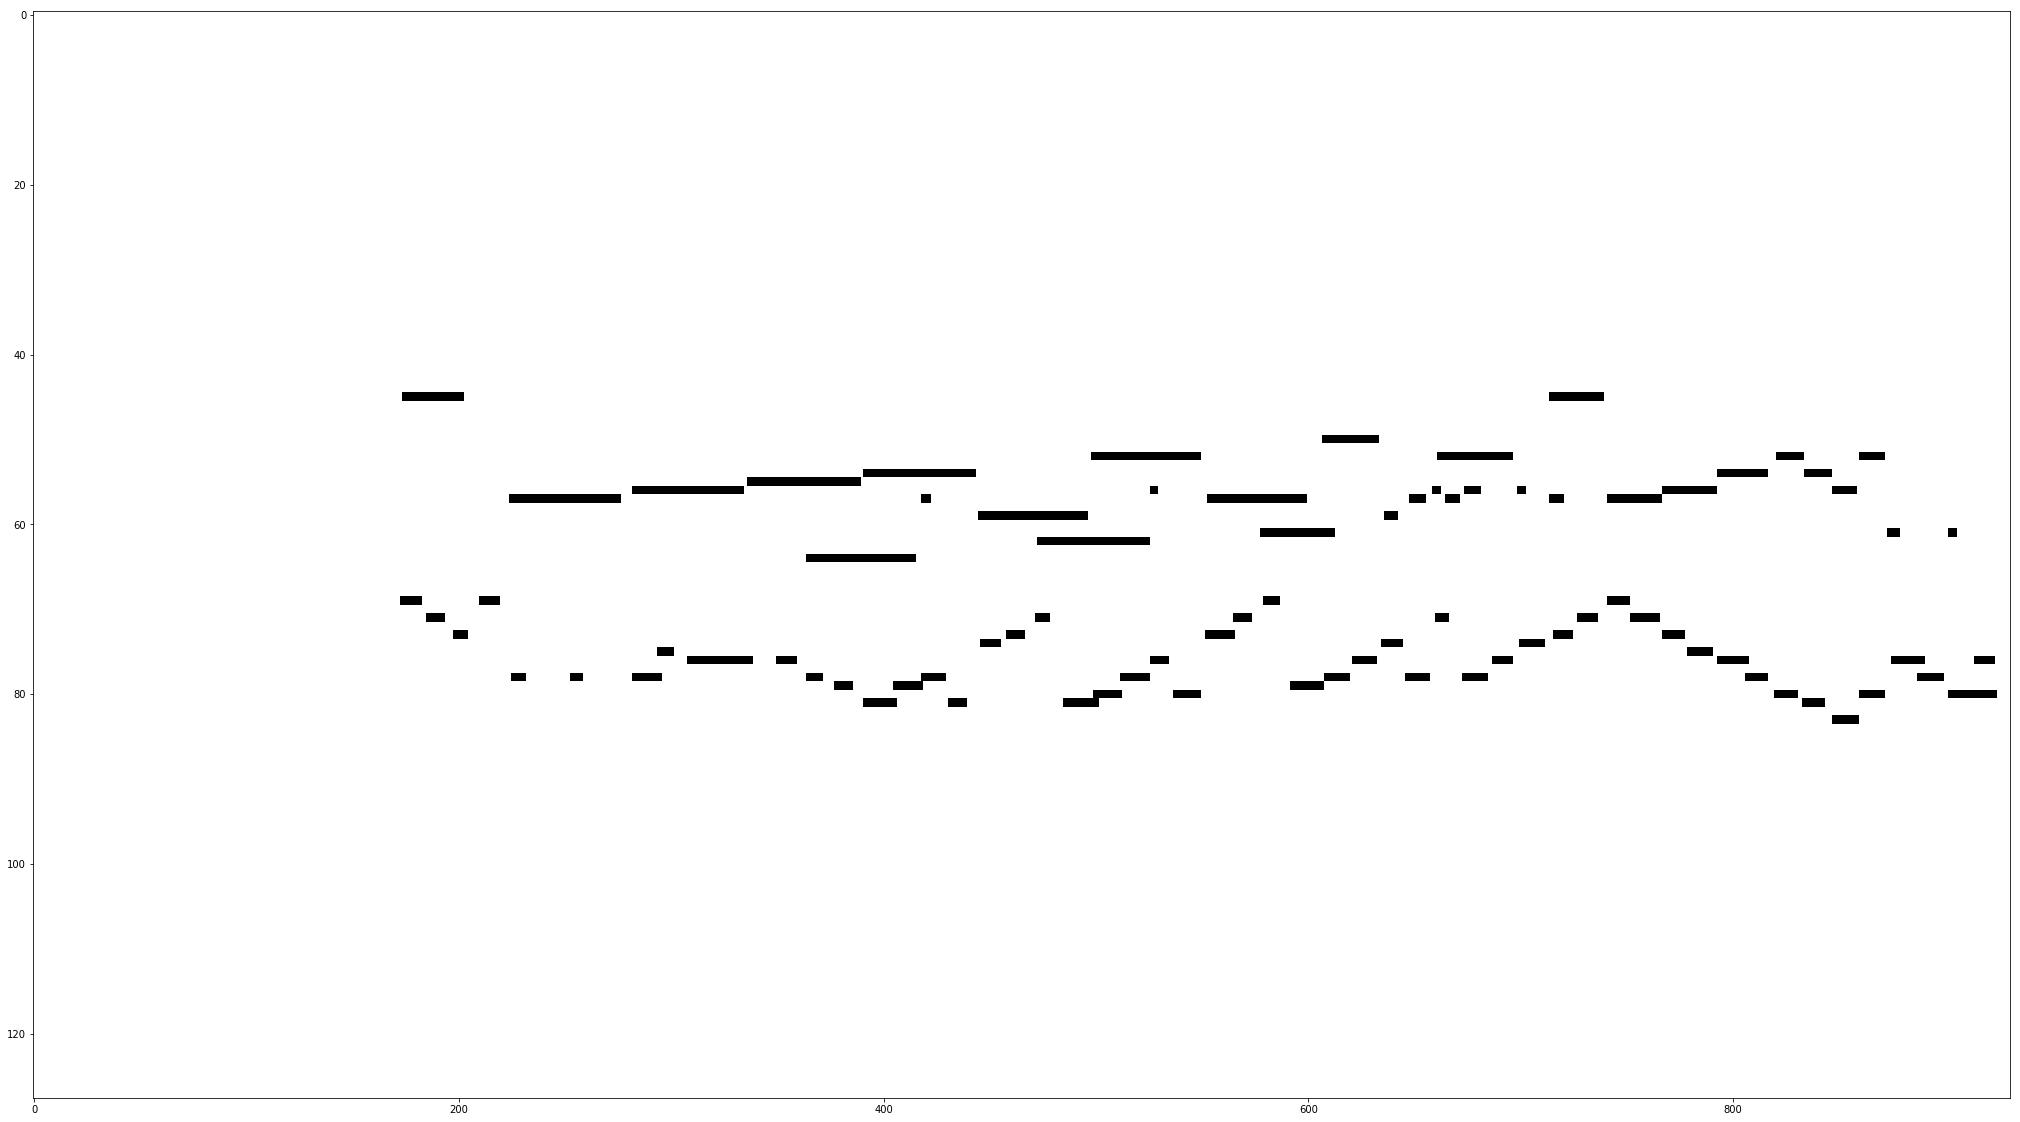

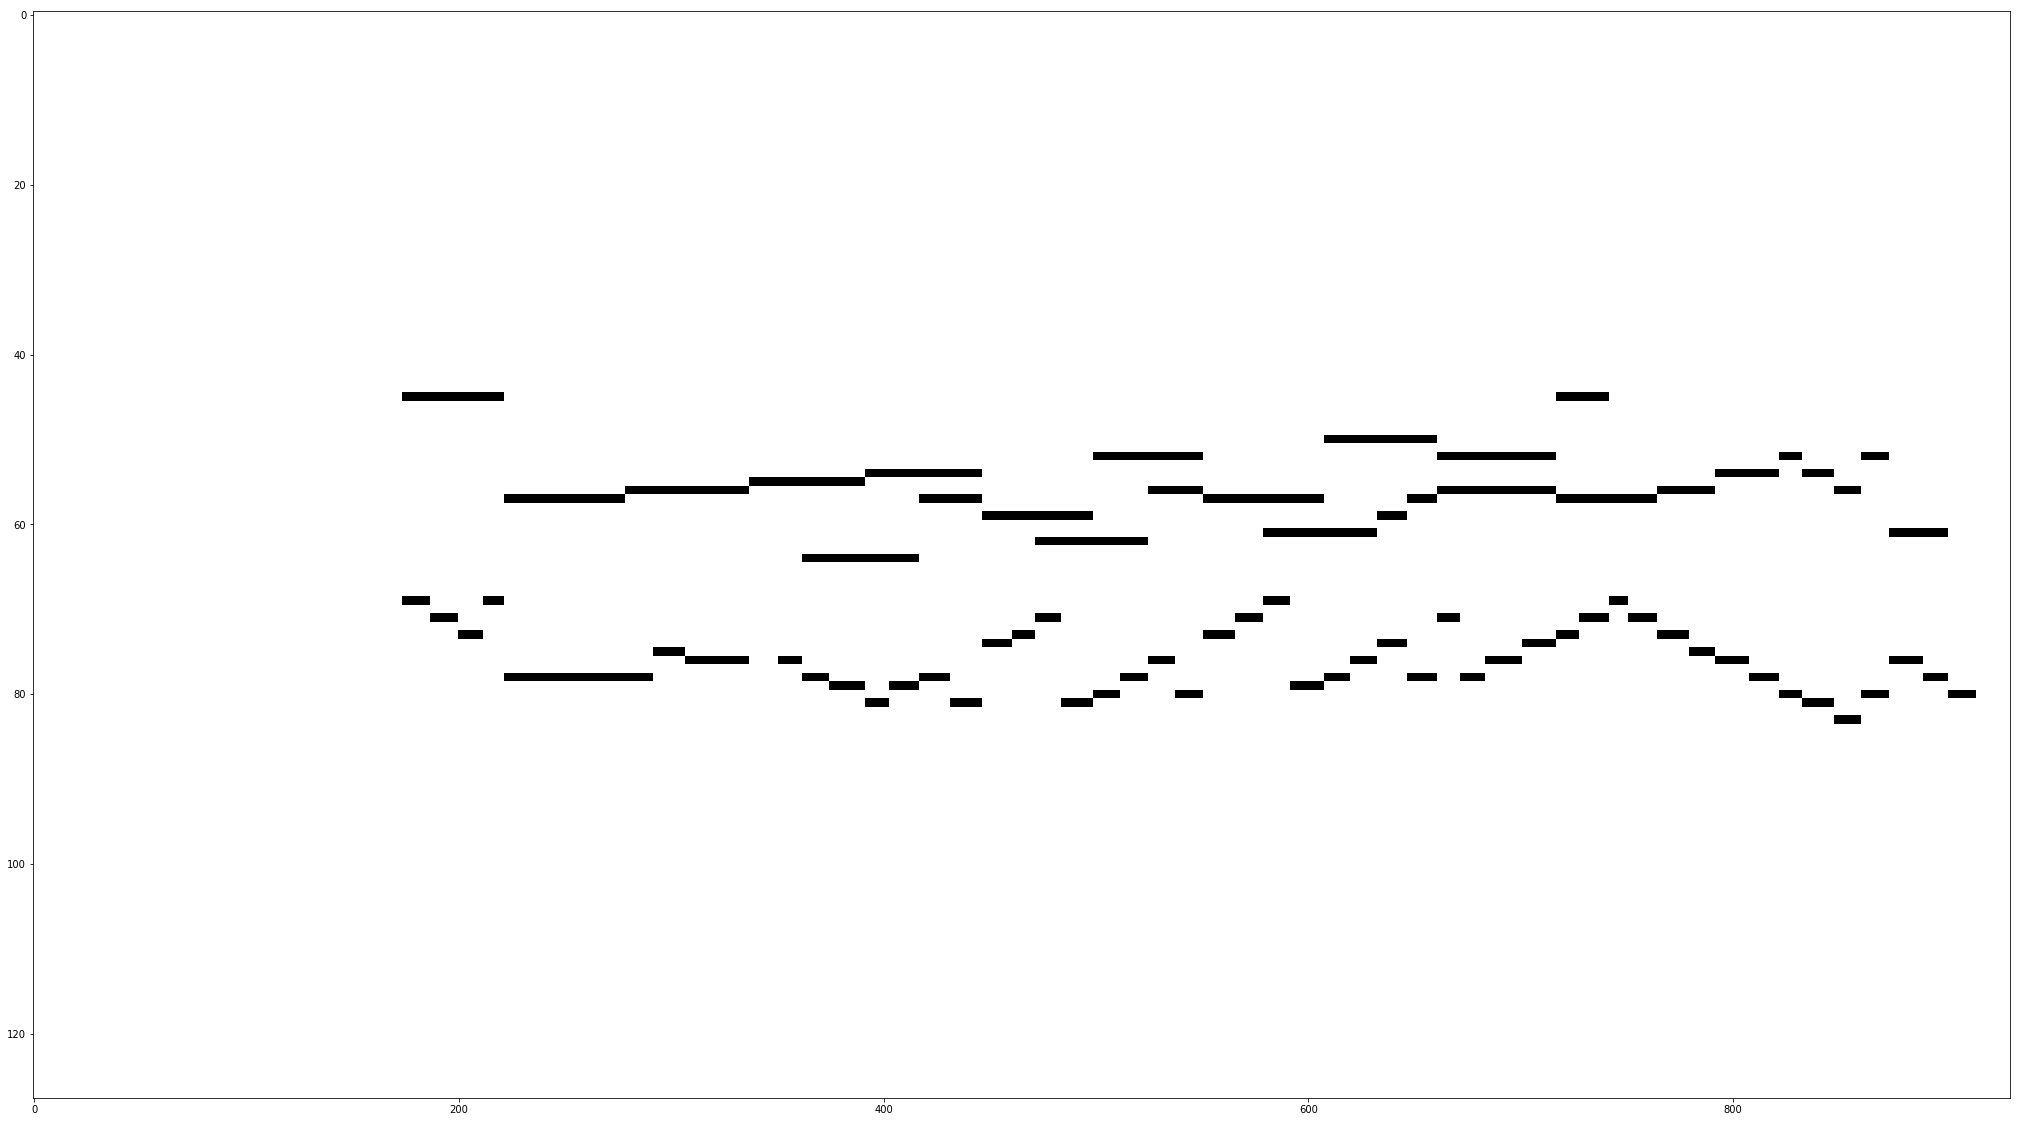

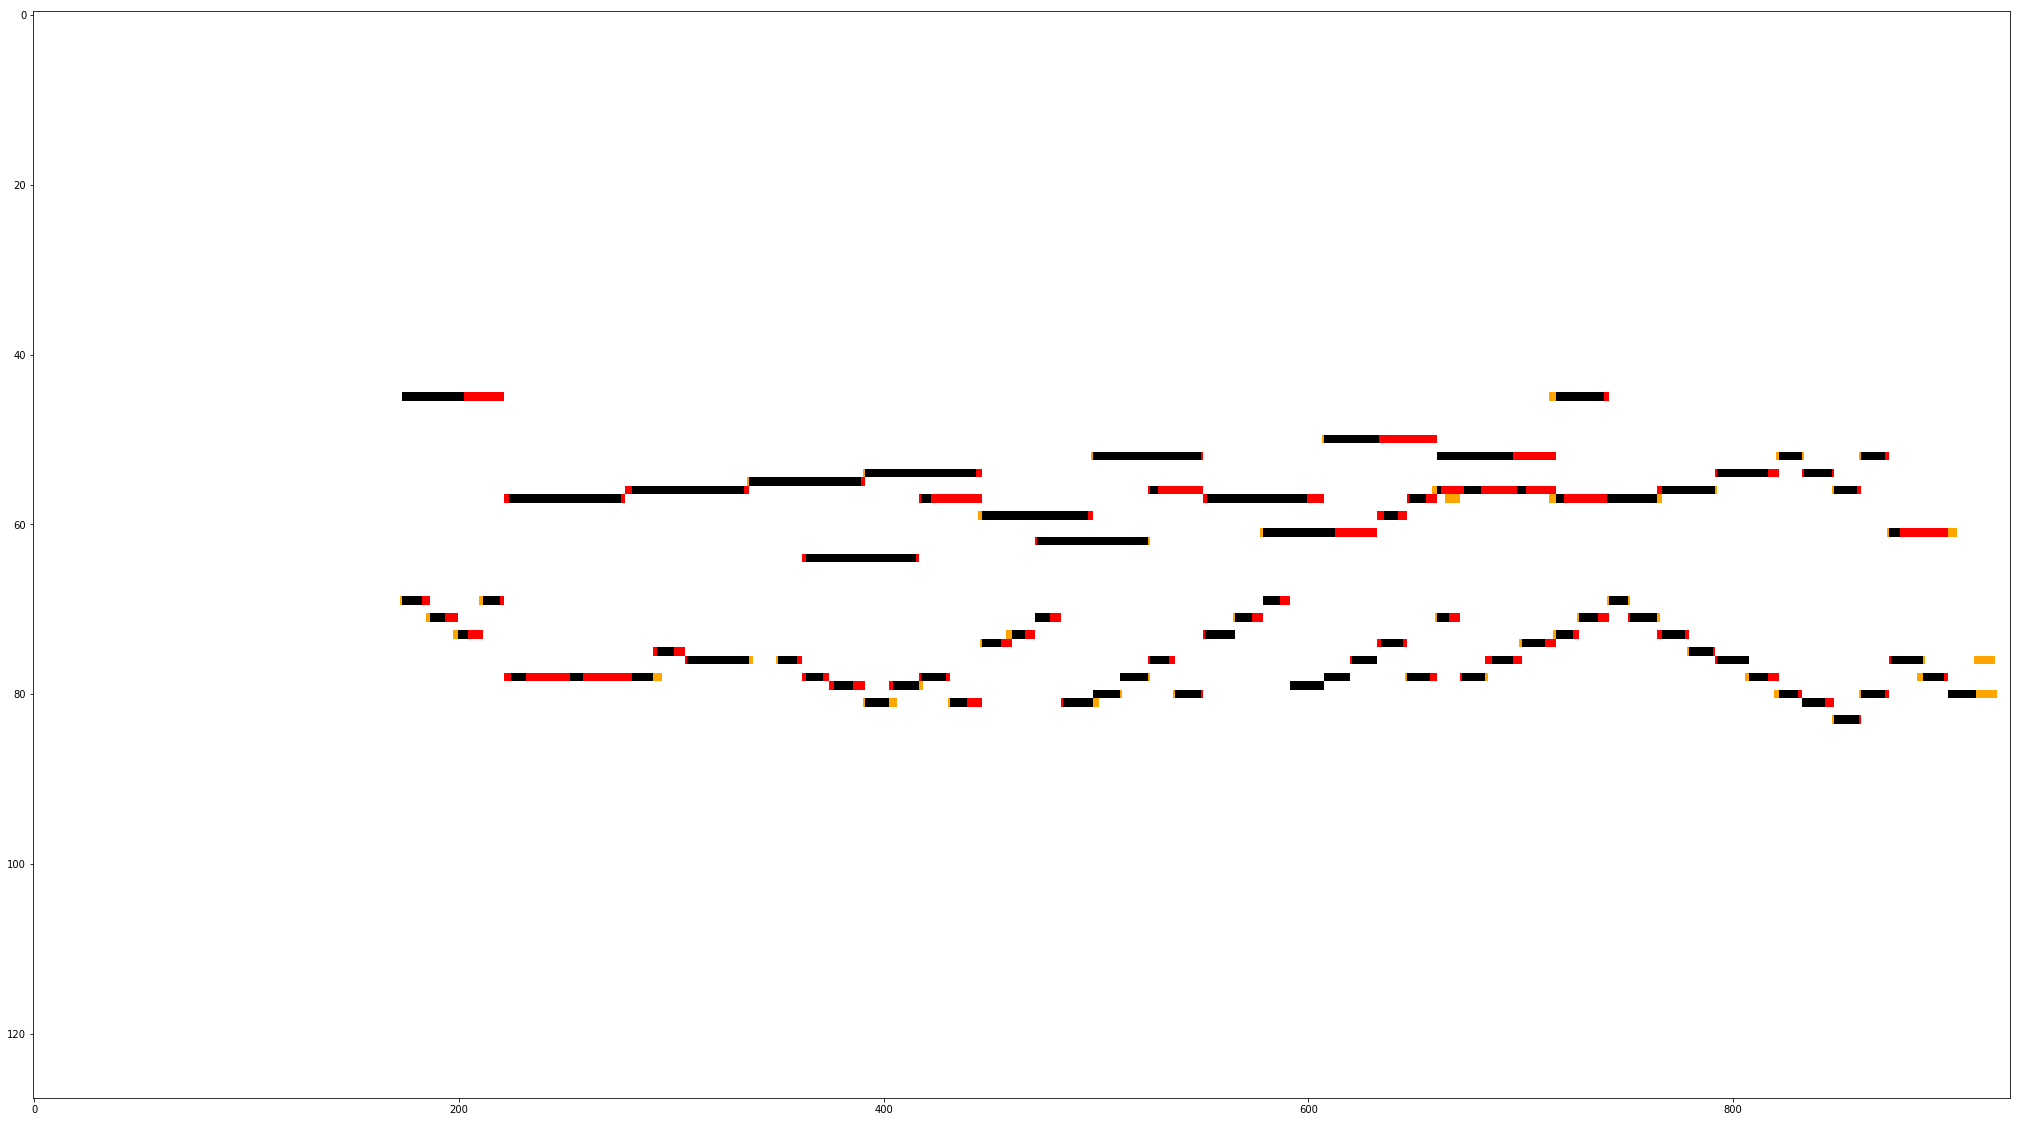

In [16]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.pyplot import figure
import numpy as np
            
def plotColorMap(x, y, figsize):
    print("white means no mistake")
    print("red means playing when not supposed to")
    print("orange means not playing when supposed to")
    print("black means playing when supposed to")
    cmap = colors.ListedColormap(['white','red','orange','black'])
    bounds = [0,1,2,3,4]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(x[::512]), interpolation='none', cmap='Greys', aspect=4)
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(y[::512]), interpolation='none', cmap='Greys', aspect=4)
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(x[::512])*2 + np.transpose(y[::512]), interpolation='none', cmap=cmap, aspect=4, norm=norm)
    
plotColorMap(x, y, (200, 20))

## Miscellaneous evaluators

In [17]:
# onsets_correct : The onsets from the maestro midi file
# onsets_predicted : The onsets generated from alignment
def evaluate_alignment(onsets_correct, onsets_predicted):
    score = 0
    for correct_onset in onsets_correct:
        found = False
        for predicted_onset in onsets_predicted:
            diff = abs(predicted_onset - correct_onset)
            if diff < 4:
                score = score + 1
                found = True
                break
        if found == False:
            print('incorrect onset : ' + str(correct_onset))
    return score

In [18]:
evaluate_alignment(onsets_correct, onsets_sig1)

NameError: name 'onsets_correct' is not defined

In [19]:
from mido import MidiFile

# Find the seperation point between Fugue and Prelude
def printSeperationPoint(filename):
    notes_onsets_offsets_correct = musiclib.load_midi(filename)
    onsets = []
    for i, e in list(enumerate(notes_onsets_offsets_correct)):
        onsets.append(e[1])
    max_diff = 0
    max_diff_index_1 = 0
    max_diff_index_2 = 0
    distinct_onsets = sorted(list(set(onsets)))
    for i, onset in enumerate(distinct_onsets):
        if (i + 1) <  len(distinct_onsets):
            diff = distinct_onsets[i + 1] - distinct_onsets[i]
            if diff > max_diff:
                max_diff = diff
                max_diff_index_1 = i
                max_diff_index_2 = i + 1

    print("maximum difference between onsets :", max_diff)
    print("index_last_prelude_note", max_diff_index_1)
    print("index_first_fugue_note", max_diff_index_2)
    print("time_last_prelude_note", distinct_onsets[max_diff_index_1], "sec")
    print("time_first_fugue_note", distinct_onsets[max_diff_index_2], "sec")

    midi = MidiFile(filename)
    print(midi.length)
    prelude_ending = (distinct_onsets[max_diff_index_1] + distinct_onsets[max_diff_index_2])/2
    # If the seperation point between fugue and prelude is not at least 10 seconds from and beginning
    # and 10 seconds from the end of the song, we have a problem.
    if ((prelude_ending > 10) and (prelude_ending < midi.length - 10)):
        print("Seperation point is at", prelude_ending, "sec")
    else:
        print("There is something weird about this piece. Please check whether either the fugue or prelude is absent.")

filename = 'bach_wtc/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_12_R2_2013_wav--1.midi'
printSeperationPoint(filename)

length of midi file265.81640625000057
maximum difference between onsets : 5.579427083333357
index_last_prelude_note 224
index_first_fugue_note 225
time_last_prelude_note 56.01302083333337 sec
time_first_fugue_note 61.59244791666673 sec
265.81640625000057
Seperation point is at 58.80273437500005 sec
